# Capstone 2: Preprocessing

## Objectives

### From Rubric:
* Creating dummy features
* Scale standardization
* Split data into training and testing subsets

### From mentor: 

## Steps:
* Identify subset of variables for modelling
    * target feature
    * explanatory features (numeric)
    * explanatory features (categorical)
* Categorical variables: dummy/one hot encode
    * create a function that does this based on a list of variables
    * check if there are any ordinal variables?
* Continuous variables: scale/normalize
    * research ways to determine best scaling method
    * create function that does this based on a list of variables
* Training/Test split
    * Consider removing Class A wildfires
    * Train/test split
        * Split 20% of data out for test set
        * confirm distributions are similar.
    * Identify correct training size (may not need everything)
        * Take a subset of your training data. Validation set.
        * Try a simple model (like a decision tree) on a a small subset and then chart performance with increasing subset size.
        * 
    * Re-introduce full set of large wildfires into the smaller training dataset (need to confirm this is okay)
* export tables for modelling:
    * test set
    * training set
    * training subset(?)
        

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
wfs = pd.read_csv('wildfires_postEDA.csv')

In [74]:
wfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83540 entries, 0 to 83539
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  83540 non-null  int64  
 1   FPA_ID                      83540 non-null  object 
 2   FIRE_NAME                   72342 non-null  object 
 3   SOURCE_REPORTING_UNIT_NAME  83540 non-null  object 
 4   FIRE_YEAR                   83540 non-null  int64  
 5   DISCOVERY_DT                83540 non-null  object 
 6   DISCOVERY_DOY               83540 non-null  int64  
 7   STAT_CAUSE_DESCR            83540 non-null  object 
 8   COUNTY_NAME                 83540 non-null  object 
 9   LATITUDE                    83540 non-null  float64
 10  LONGITUDE                   83540 non-null  float64
 11  geometry                    83540 non-null  object 
 12  FIRE_SIZE                   83540 non-null  float64
 13  FIRE_SIZE_CLASS             835

In [75]:
wfs.columns

Index(['Unnamed: 0', 'FPA_ID', 'FIRE_NAME', 'SOURCE_REPORTING_UNIT_NAME',
       'FIRE_YEAR', 'DISCOVERY_DT', 'DISCOVERY_DOY', 'STAT_CAUSE_DESCR',
       'COUNTY_NAME', 'LATITUDE', 'LONGITUDE', 'geometry', 'FIRE_SIZE',
       'FIRE_SIZE_CLASS', 'elevation', 'slope', 'aspect', 'mean_monthly_ppt',
       'dew_point', 'max_temp', 'wind_speed', 'erc', 'bi', 'fm100', 'fm1000',
       'WHRNAME', 'WHR10NAME', 'US_L3NAME', 'NA_L2NAME', 'usda_bp', 'usda_fi1',
       'usda_fi2', 'usda_fi3', 'usda_fi4', 'usda_fi5', 'usda_fi6',
       'DISCOVERY_MONTH', 'monthly_large_wf', 'aspect_cat', 'FIRE_SIZE_log',
       'FIRE_SIZE_boxcox'],
      dtype='object')

In [76]:
target_feature = ['FIRE_SIZE_CLASS']

# reminder: aspect, mean_monthly_ppt, bi do not appear to have good predictive power
exp_cont = ['LATITUDE', 'LONGITUDE','elevation', 'slope', 'aspect', 'mean_monthly_ppt',
            'dew_point', 'max_temp', 'wind_speed', 'erc', 'bi', 'fm100', 'fm1000','usda_bp',
            'usda_fi1', 'usda_fi2', 'usda_fi3', 'usda_fi4','monthly_large_wf']

# reminder: unclear if discovery month should be nominal or ordinanal
exp_cat = ['DISCOVERY_MONTH','WHR10NAME', 'aspect_cat','NA_L2NAME','US_L3NAME']

In [78]:
#override negative elevations to be 0 (to avoid scaling issues later on)
#wfs.elevation[wfs.elevation < 0] = 0
wfs.elevation = wfs.elevation.clip(lower=0)

In [120]:
#what happens if we drop all FIRE_SIZE_CLASS = A?

wfs = wfs[wfs.FIRE_SIZE_CLASS != 'A']

In [121]:
wfs.shape

(40603, 41)

## Transforming Continuous Variables

In [122]:
# get summary statistics + skew/kurtosis
wfs_describe = wfs[exp_cont].describe().T
wfs_describe['skew'] = wfs[wfs_describe.index].skew()
bins=[0, 0.5, 1, 10]
labels=['Low', 'Med', 'High']
wfs_describe['skew_class'] = pd.cut(abs(wfs_describe['skew']), bins, labels=labels, ordered=False, include_lowest=True)
wfs_describe['kurtosis'] = wfs[wfs_describe.index].kurtosis()

In [123]:
# removing negative/0 values by adding absolute value of min val to columns with mins <=0
wfs_no_zeros = wfs[exp_cont]
for col in wfs_no_zeros.columns:
    if wfs_no_zeros[col].min() <= 0:
        wfs_no_zeros.loc[:,col] = wfs_no_zeros[col] + abs(wfs_no_zeros[col].min()) + 0.0001

/Users/allankapoor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [124]:
# get summary statistics + skew/kurtosis for 
wfs_noZ_describe = wfs_no_zeros.describe().T
wfs_noZ_describe['skew'] = wfs[wfs_noZ_describe.index].skew()
bins=[0, 0.5, 1, 10]
labels=['Low', 'Med', 'High']
wfs_noZ_describe['skew_class'] = pd.cut(abs(wfs_noZ_describe['skew']), bins, labels=labels, ordered=False, include_lowest=True)
wfs_noZ_describe['kurtosis'] = wfs[wfs_noZ_describe.index].kurtosis()
wfs_noZ_describe

,count,mean,std,min,25%,50%,75%,max,skew,skew_class,kurtosis
LATITUDE,40603.0,37.426451,2.427785,32.552743,35.661393,37.463758,39.308375,42.007800,-0.185589,Low,-0.951326
LONGITUDE,40603.0,4.042380,2.061663,0.000100,2.593797,3.716220,5.377835,10.243900,0.445611,Low,-0.579478
elevation,40603.0,479.978253,522.349135,0.000100,91.553975,291.496530,697.506700,3795.679300,1.661633,High,2.763476
slope,40603.0,6.832351,8.455206,0.000100,0.817248,3.276110,9.741365,73.758584,1.754441,High,2.930586
aspect,40603.0,179.151344,99.709393,0.000100,93.786073,185.855030,260.518745,359.999250,-0.103933,Low,-1.060810
mean_monthly_ppt,40603.0,48.271094,37.757627,0.006417,21.383917,37.337917,63.223747,354.849426,1.755768,High,4.288230
dew_point,40603.0,27.018158,4.981725,0.000100,24.094886,27.798243,30.714529,43.502101,-0.800571,Med,0.775241
max_temp,40603.0,28.360956,6.533056,0.305143,24.076358,29.365000,33.407572,45.421288,-0.568374,Med,-0.159920
wind_speed,40603.0,3.403939,1.541796,0.359634,2.414889,3.063977,3.999138,15.806997,1.814152,High,5.546374
erc,40603.0,61.881827,17.814508,0.000100,49.045733,63.397542,75.613137,114.702241,-0.301532,Low,-0.444059


In [125]:
def test_transformations(df, col):
        '''
        For col in df, tests several transformations and returns the best transformation and the resulting skew
        '''
    
        #get skew of different transformations
        orig = df[col].skew()
        logn = np.log(df[col]).skew()
        log10 = np.log10(df[col]).skew()
        sqrt = np.sqrt(df[col]).skew()
        cbrt = np.cbrt(df[col]).skew()
        #recip = (1 / df[col]).skew()
        sq = (df[col]**2).skew()
        cb = (df[col]**3).skew()
        
        transformation_list = ['none','logn','log10','sqrt','cbrt','sq','cb'] # 'recip'
        skew_list = [abs(x) for x in [orig, logn, log10, sqrt, cbrt, sq, cb]] # recip
        
        #find min skew
        min_skew = min(skew_list)
        min_index = skew_list.index(min_skew)
        best_transformation = transformation_list[min_index]
        
        print(f'best transformation: {best_transformation}')
        
        print(f'orig skew: {round(orig,3)}')
        print(f'logn skew: {round(logn,3)}')
        print(f'log10 skew: {round(log10,3)}')
        print(f'sqrt skew: {round(sqrt,3)}')
        print(f'cbrt skew: {round(cbrt,3)}')
        #print(f'recip skew: {round(recip,3)}')
        print(f'sq skew: {round(sq,3)}')
        print(f'cb skew: {round(cb,3)}')
        
        return best_transformation, min_skew

In [126]:
#test transformation for each explanatory feature and record

for col in wfs_no_zeros.columns:
    print(f'------- {col} -------')
    
    best, skew = test_transformations(wfs_no_zeros, col)
    
    wfs_noZ_describe.loc[col,'best_trans'] = best
    wfs_noZ_describe.loc[col,'abs_trans_skew'] = skew

------- LATITUDE -------
best transformation: cb
orig skew: -0.186
logn skew: -0.284
log10 skew: -0.284
sqrt skew: -0.235
cbrt skew: -0.251
sq skew: -0.086
cb skew: 0.014
------- LONGITUDE -------
best transformation: sqrt
orig skew: 0.446
logn skew: -1.271
log10 skew: -1.271
sqrt skew: -0.171
cbrt skew: -0.446
sq skew: 1.214
cb skew: 1.806
------- elevation -------
best transformation: cbrt
orig skew: 1.662
logn skew: -4.341
log10 skew: -4.341
sqrt skew: 0.676
cbrt skew: 0.259
sq skew: 3.699
cb skew: 6.177
------- slope -------
best transformation: cbrt
orig skew: 1.754
logn skew: -1.958
log10 skew: -1.958
sqrt skew: 0.728
cbrt skew: 0.282
sq skew: 3.84
cb skew: 7.934
------- aspect -------
best transformation: none
orig skew: -0.104
logn skew: -5.253
log10 skew: -5.253
sqrt skew: -0.835
cbrt skew: -1.379
sq skew: 0.645
cb skew: 1.163
------- mean_monthly_ppt -------
best transformation: cbrt
orig skew: 1.756
logn skew: -0.67
log10 skew: -0.67
sqrt skew: 0.708
cbrt skew: 0.35
sq skew:

In [127]:
wfs_noZ_describe['trans_skew_class'] = pd.cut(wfs_noZ_describe['abs_trans_skew'], bins, labels=labels, ordered=False, include_lowest=True)

wfs_noZ_describe[['skew','skew_class','best_trans','abs_trans_skew','trans_skew_class']].sort_values('abs_trans_skew', ascending=False)

,skew,skew_class,best_trans,abs_trans_skew,trans_skew_class
usda_fi1,3.485790,High,log10,0.885513,Med
bi,-0.531552,Med,none,0.531552,Med
usda_bp,3.147001,High,cbrt,0.452924,Low
mean_monthly_ppt,1.755768,High,cbrt,0.349571,Low
erc,-0.301532,Low,none,0.301532,Low
slope,1.754441,High,cbrt,0.282283,Low
monthly_large_wf,1.344422,High,cbrt,0.269315,Low
elevation,1.661633,High,cbrt,0.259248,Low
usda_fi4,1.655752,High,log10,0.255755,Low
dew_point,-0.800571,Med,cb,0.218016,Low


In [128]:
wfs_noZ_describe.loc['erc','best_trans']

'none'

In [129]:
wfs_trans = wfs_no_zeros.copy()

for col in wfs_trans:
    
    #get best transformation
    trans = wfs_noZ_describe.loc[col,'best_trans']
    
    #apply best transformation
    if trans == 'none':
        wfs_trans[col] = wfs_trans[col]
    elif trans == 'logn':
        wfs_trans[col] = np.log(wfs_trans[col])
    elif trans == 'log10':
        wfs_trans[col] = np.log10(wfs_trans[col])
    elif trans == 'sqrt':
        wfs_trans[col] = np.sqrt(wfs_trans[col])
    elif trans == 'cbrt':
        wfs_trans[col] = np.cbrt(wfs_trans[col])
    elif trans == 'recip':
        wfs_trans[col] = 1/wfs_trans[col]
    elif trans == 'sq':
        wfs_trans[col] = wfs_trans[col]**2
    elif trans == 'cb':
        wfs_trans[col] = wfs_trans[col]**3
    else:
        print(f'error at {col}')

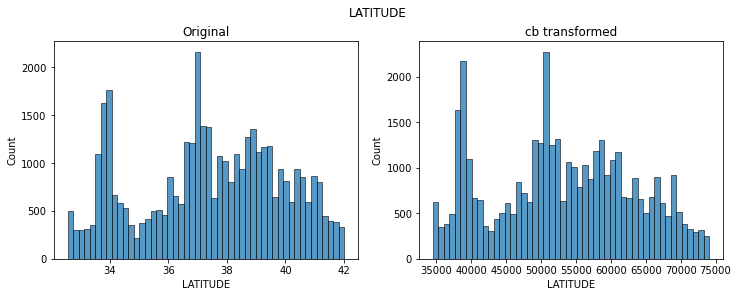

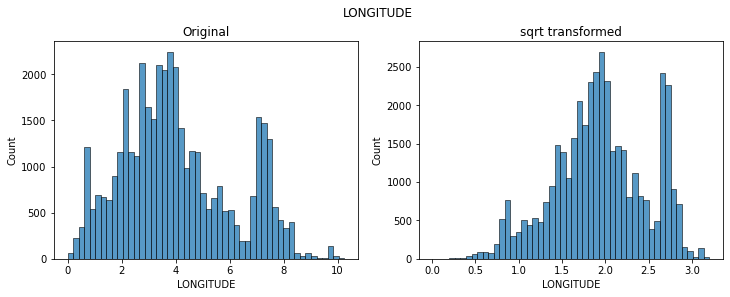

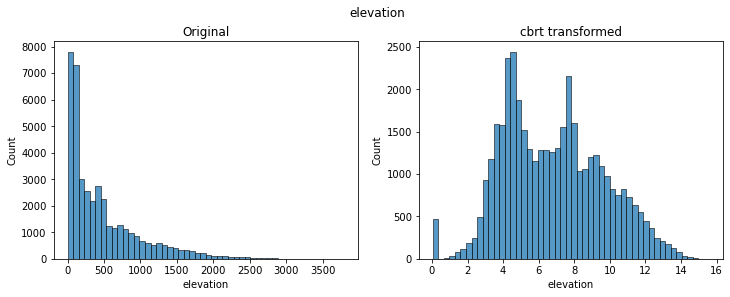

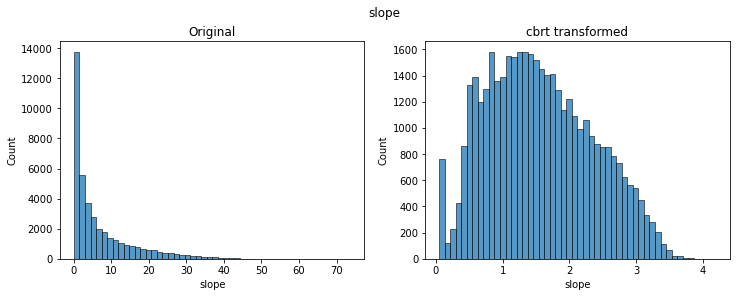

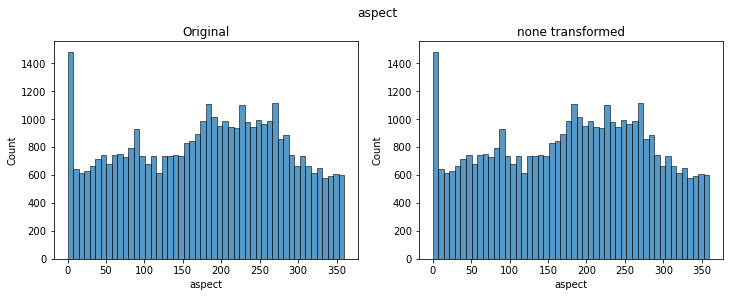

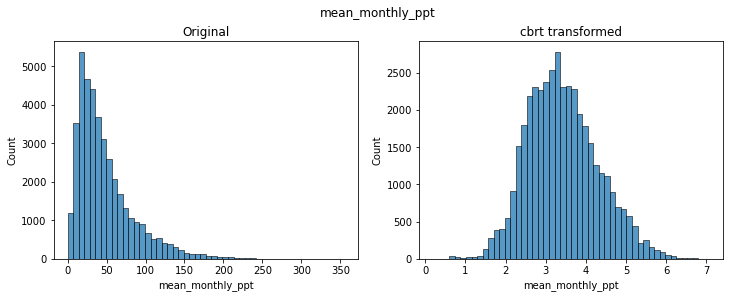

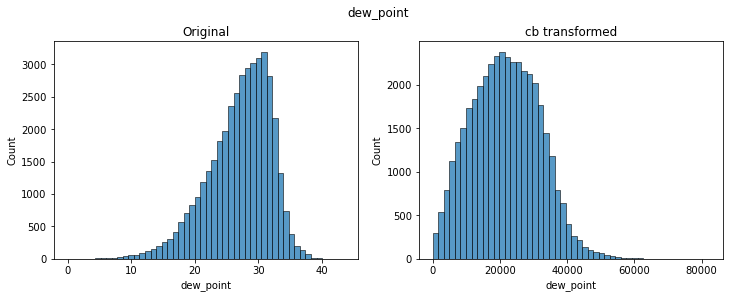

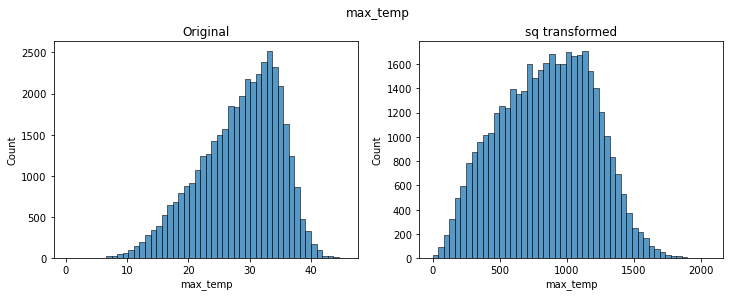

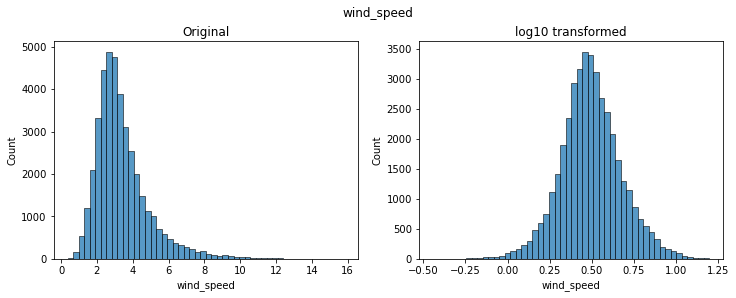

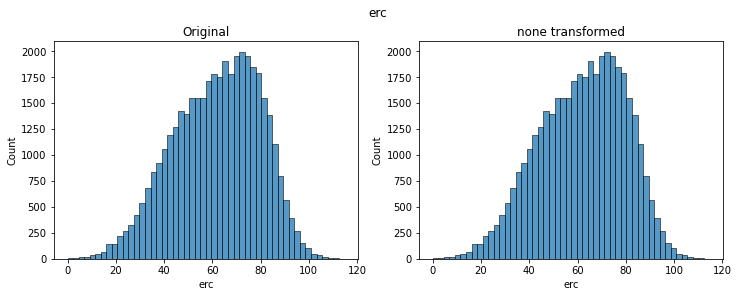

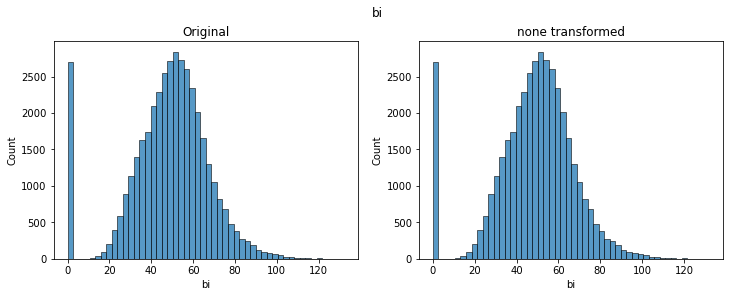

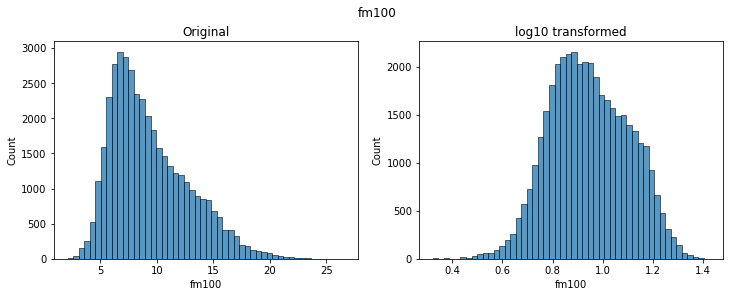

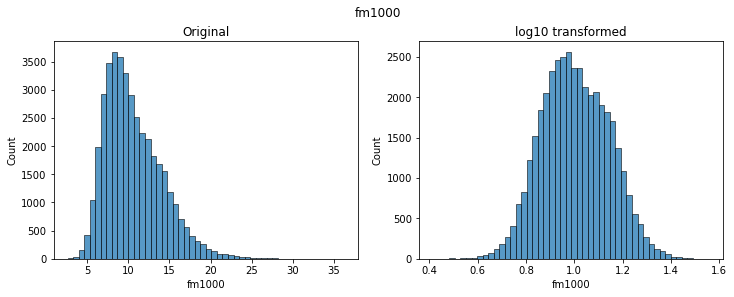

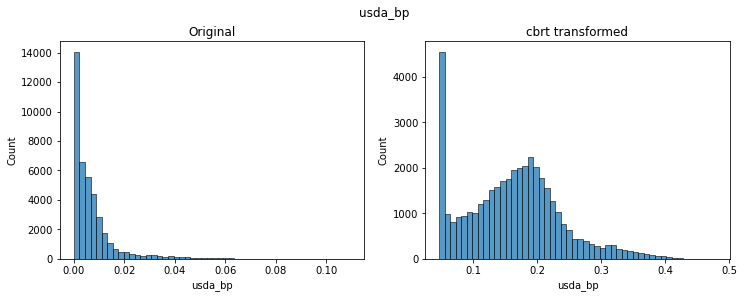

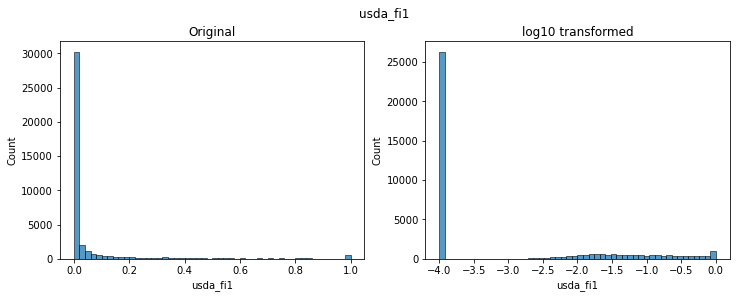

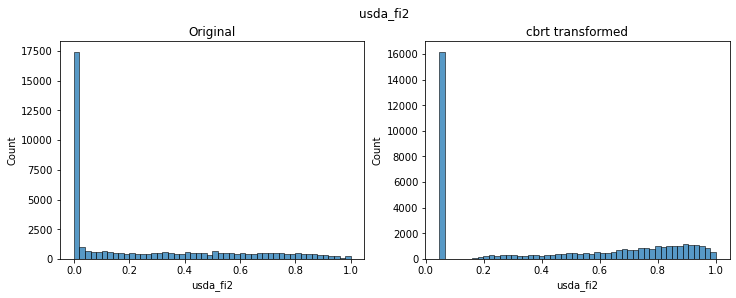

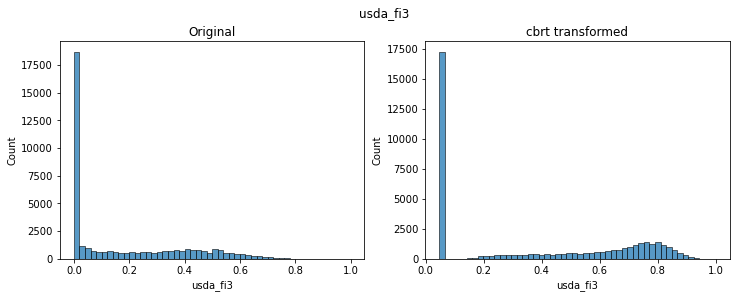

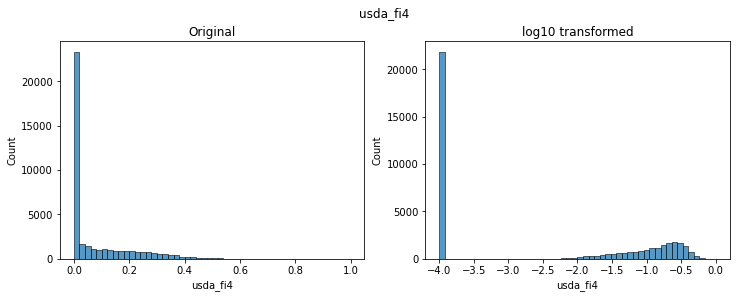

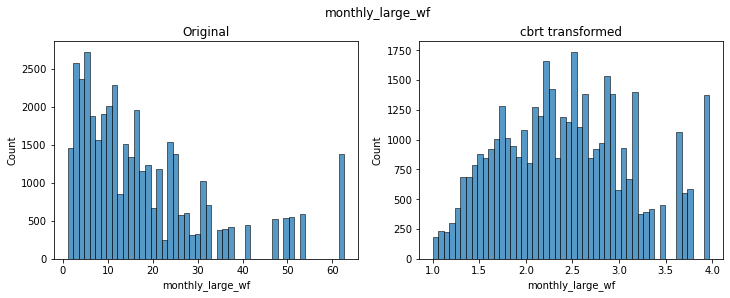

In [130]:
for col in wfs_trans.columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

    sns.histplot(x=col, data=wfs_no_zeros, bins=50, ax=ax1)
    ax1.set_title('Original')

    sns.histplot(x=col, data=wfs_trans, bins=50, ax=ax2)
    title = wfs_noZ_describe.loc[col,'best_trans']
    ax2.set_title(f'{title} transformed')

    fig.suptitle(col, y=1.0) 

    plt.show();

In [131]:
wfs_trans.head()

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf
1,63268.140847,2.023119,11.845419,2.414584,45.13996,3.940440,3370.826396,185.948290,0.606454,31.053229,29.961724,1.126366,1.268039,0.143987,-0.969631,0.793753,0.685078,-1.145518,1.310371
4,62997.282739,1.954257,11.635882,1.846491,167.01350,3.941304,1128.748466,148.920193,0.678806,45.308881,44.245637,1.027967,1.149550,0.187674,-4.000000,0.313695,0.639588,-0.557484,1.310371
5,62985.409154,1.975112,11.464129,1.163283,324.95300,3.646062,1057.364686,156.367873,0.652441,42.349519,40.321435,1.046028,1.171934,0.177523,-1.438136,0.851914,0.689204,-1.737976,1.310371
6,64632.740505,1.880443,10.257326,2.775995,268.48042,4.728582,2894.485059,124.099586,0.758136,17.560101,0.000101,1.169783,1.300238,0.211271,-4.000000,0.320970,0.784935,-0.578666,1.310371
7,62732.461313,1.960856,11.107087,1.308573,254.73255,4.313399,3051.662747,106.313768,0.734011,45.714009,48.972016,1.057925,1.162887,0.171762,-1.696804,0.920556,0.584901,-4.000000,1.310371


## Scaling Continuous Data

Summary of different scaling options:

https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

https://www.kaggle.com/getting-started/113219



In [132]:
wfs_trans.describe()

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf
count,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000,4.060300e+04,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000,40603.000000
mean,53083.816396,1.937694,6.802559,1.559579,179.151344,3.420867,2.163529e+04,847.023603,0.494009,61.881827,48.342235,0.943766,1.003844,0.161803,-3.009628,0.440094,0.382626,-2.582825,2.427265
std,10130.404874,0.536405,2.795912,0.787459,99.709393,0.882835,1.010395e+04,350.276798,0.179605,17.814508,19.457751,0.156596,0.138584,0.075861,1.406723,0.361382,0.323049,1.559010,0.703080
min,34495.525756,0.010000,0.046416,0.046416,0.000100,0.185825,1.000000e-12,0.093112,-0.444139,0.000100,0.000100,0.322353,0.414144,0.046416,-4.000000,0.046416,0.046416,-4.000000,1.000000
25%,45351.839869,1.610527,4.507050,0.934942,93.786073,2.775635,1.398861e+04,579.671007,0.382897,49.045733,38.641625,0.828269,0.903390,0.106374,-4.000000,0.046416,0.046416,-4.000000,1.871980
50%,52581.626782,1.927750,6.630472,1.485204,185.855030,3.342335,2.148088e+04,862.303212,0.486286,63.397542,50.035618,0.934814,0.997533,0.163427,-4.000000,0.464314,0.364162,-4.000000,2.404967
75%,60737.271346,2.319016,8.868486,2.135698,260.518745,3.983762,2.897554e+04,1116.065853,0.601966,75.613137,60.131875,1.061605,1.104941,0.206391,-1.670053,0.795673,0.718168,-0.871510,2.920505
max,74129.285266,3.200609,15.598991,4.193766,359.999250,7.079698,8.232480e+04,2063.093361,1.198849,114.702241,132.171216,1.424705,1.559613,0.478680,0.000043,1.000033,1.000033,0.000043,3.971464


In [133]:
# for now, scaling all variables using min-max scaler:

wfs_trans_scaled = wfs_trans.copy()

In [134]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

for col in wfs_trans_scaled.columns:

    #instantiate scaler
    MMscaler = MinMaxScaler()
    
    #fit scaler
    MMscaler.fit(wfs_trans[[col]])
    
    #transform
    wfs_trans_scaled[col] = MMscaler.transform(wfs_trans[[col]])


In [135]:
wfs_trans_scaled.head()

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf
1,0.725962,0.630951,0.758653,0.571008,0.125389,0.544631,0.040945,0.090090,0.639440,0.270728,2.266881e-01,0.729362,0.745454,0.225721,0.757584,0.783687,0.669726,0.713613,0.10445
4,0.719128,0.609369,0.745180,0.434030,0.463927,0.544756,0.013711,0.072141,0.683477,0.395013,3.347595e-01,0.640099,0.642013,0.326787,0.000000,0.280279,0.622023,0.860620,0.10445
5,0.718829,0.615905,0.734137,0.269297,0.902649,0.501929,0.012844,0.075751,0.667430,0.369212,3.050692e-01,0.656483,0.661554,0.303304,0.640459,0.844676,0.674052,0.565500,0.10445
6,0.760393,0.586234,0.656541,0.658150,0.745780,0.658956,0.035159,0.060110,0.731761,0.153092,5.214291e-09,0.768748,0.773564,0.381375,0.000000,0.287908,0.774439,0.855324,0.10445
7,0.712447,0.611437,0.711179,0.304329,0.707592,0.598731,0.037069,0.051488,0.717077,0.398545,3.705190e-01,0.667275,0.653656,0.289976,0.575793,0.916657,0.564676,0.000000,0.10445


In [136]:
#confirming everything is scaled correctly
wfs_trans_scaled.describe().loc[['min','max','mean','50%'],:]

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000
mean,0.469001,0.604177,0.434407,0.364851,0.497644,0.469263,0.262804,0.410533,0.571001,0.539499,0.365754,0.563716,0.514811,0.266936,0.24759,0.412826,0.352563,0.35429,0.480324
50%,0.456331,0.601061,0.423342,0.346918,0.516265,0.457872,0.260928,0.417940,0.566300,0.552714,0.378566,0.555595,0.509301,0.270693,0.00000,0.438224,0.333201,0.00000,0.472820


In [137]:
pd.concat([wfs_trans_scaled.elevation.rename('elevation_scaled'),
           wfs_trans.elevation.rename('elevation_trans'),
           wfs.elevation.rename('elevation_orig')], axis=1).sort_values('elevation_orig', ascending=False)

,elevation_scaled,elevation_trans,elevation_orig
44173,1.000000,15.598991,3795.6792
13682,0.962540,15.016392,3386.0764
10529,0.950223,14.824833,3258.1377
36555,0.949451,14.812822,3250.2246
11820,0.948104,14.791869,3236.4520
...,...,...,...
51251,0.000000,0.046416,0.0000
51242,0.000000,0.046416,0.0000
51235,0.000000,0.046416,0.0000
51224,0.000000,0.046416,0.0000


## Encoding Categorical Data

Discovery Month - convert to categorical, make sin/cosin

In [138]:
wfs[exp_cat]

,DISCOVERY_MONTH,WHR10NAME,aspect_cat,NA_L2NAME,US_L3NAME
1,2,Shrub,NE,WESTERN CORDILLERA,Sierra Nevada
4,2,Conifer,S,WESTERN CORDILLERA,Sierra Nevada
5,2,Hardwood,NW,WESTERN CORDILLERA,Sierra Nevada
6,2,Conifer,W,WESTERN CORDILLERA,Sierra Nevada
7,2,Herbaceous,W,WESTERN CORDILLERA,Sierra Nevada
...,...,...,...,...,...
83532,2,Urban,N,MEDITERRANEAN CALIFORNIA,Central California Foothills and Coastal Mount...
83534,1,Herbaceous,NE,MEDITERRANEAN CALIFORNIA,Central California Foothills and Coastal Mount...
83535,1,Shrub,S,MEDITERRANEAN CALIFORNIA,Central California Foothills and Coastal Mount...
83537,12,Agriculture,N,MEDITERRANEAN CALIFORNIA,Central California Valley


In [139]:
def see_uniques(df):
    ''' print unique values of each obj column'''
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f'----- {col} -----')
            print(f'Num categories: {df[col].nunique()}')
            print(df[col].unique())

In [140]:
exp_cat

['DISCOVERY_MONTH', 'WHR10NAME', 'aspect_cat', 'NA_L2NAME', 'US_L3NAME']

In [141]:
#simplifying category names 
wfs_cat = wfs[exp_cat]
for col in exp_cat[1:]:
    
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace(' ', '_')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('/', '_')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('California', 'CA')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('CALIFORNIA', 'CA')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('Southern', 'S')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('Northern', 'N')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('North', 'N')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('Eastern', 'E')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('WESTERN', 'W')
    wfs_cat.loc[:,col] = wfs_cat[col].str.replace('WEST', 'W')
    
see_uniques(wfs_cat)

/Users/allankapoor/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


----- WHR10NAME -----
Num categories: 10
['Shrub' 'Conifer' 'Hardwood' 'Herbaceous' 'Wetland' 'Water' 'Agriculture'
 'Urban' 'Barren_Other' 'Desert']
----- aspect_cat -----
Num categories: 8
['NE' 'S' 'NW' 'W' 'N' 'SW' 'E' 'SE']
----- NA_L2NAME -----
Num categories: 5
['W_CORDILLERA' 'MEDITERRANEAN_CA' 'MARINE_W_COAST_FOREST' 'WARM_DESERTS'
 'COLD_DESERTS']
----- US_L3NAME -----
Num categories: 13
['Sierra_Nevada' 'Klamath_Mountains_CA_High_N_Coast_Range'
 'Central_CA_Foothills_and_Coastal_Mountains' 'Cascades'
 'E_Cascades_Slopes_and_Foothills' 'Coast_Range' 'S_CA_Mountains'
 'S_CA_N_Baja_Coast' 'Mojave_Basin_and_Range' 'Central_Basin_and_Range'
 'Sonoran_Basin_and_Range' 'Central_CA_Valley' 'N_Basin_and_Range']


In [142]:
#creating dummies for categorical features
wfs_cat_dummies = pd.get_dummies(wfs_cat, columns=['DISCOVERY_MONTH'], drop_first=True, prefix='MONTH')
wfs_cat_dummies = pd.get_dummies(wfs_cat_dummies, columns=['aspect_cat'], drop_first=True, prefix='ASPECT')
wfs_cat_dummies = pd.get_dummies(wfs_cat_dummies, columns=['WHR10NAME'], drop_first=True, prefix='WHR10')
wfs_cat_dummies = pd.get_dummies(wfs_cat_dummies, columns=['NA_L2NAME'], drop_first=True, prefix='L2')
wfs_cat_dummies = pd.get_dummies(wfs_cat_dummies, columns=['US_L3NAME'], drop_first=True, prefix='L3')
wfs_cat_dummies.columns

Index(['MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6', 'MONTH_7',
       'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12', 'ASPECT_N',
       'ASPECT_NE', 'ASPECT_NW', 'ASPECT_S', 'ASPECT_SE', 'ASPECT_SW',
       'ASPECT_W', 'WHR10_Barren_Other', 'WHR10_Conifer', 'WHR10_Desert',
       'WHR10_Hardwood', 'WHR10_Herbaceous', 'WHR10_Shrub', 'WHR10_Urban',
       'WHR10_Water', 'WHR10_Wetland', 'L2_MARINE_W_COAST_FOREST',
       'L2_MEDITERRANEAN_CA', 'L2_WARM_DESERTS', 'L2_W_CORDILLERA',
       'L3_Central_Basin_and_Range',
       'L3_Central_CA_Foothills_and_Coastal_Mountains', 'L3_Central_CA_Valley',
       'L3_Coast_Range', 'L3_E_Cascades_Slopes_and_Foothills',
       'L3_Klamath_Mountains_CA_High_N_Coast_Range',
       'L3_Mojave_Basin_and_Range', 'L3_N_Basin_and_Range',
       'L3_S_CA_Mountains', 'L3_S_CA_N_Baja_Coast', 'L3_Sierra_Nevada',
       'L3_Sonoran_Basin_and_Range'],
      dtype='object')

## Merge

Need to merge:
* wfs_trans_scaled
* wfs_cat_dummies
* wfs_ord (?)

In [143]:
wfs_cat_dummies

,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,...,L3_Central_CA_Valley,L3_Coast_Range,L3_E_Cascades_Slopes_and_Foothills,L3_Klamath_Mountains_CA_High_N_Coast_Range,L3_Mojave_Basin_and_Range,L3_N_Basin_and_Range,L3_S_CA_Mountains,L3_S_CA_N_Baja_Coast,L3_Sierra_Nevada,L3_Sonoran_Basin_and_Range
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83532,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83537,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [144]:
wfs_trans_scaled

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,bi,fm100,fm1000,usda_bp,usda_fi1,usda_fi2,usda_fi3,usda_fi4,monthly_large_wf
1,0.725962,0.630951,0.758653,0.571008,0.125389,0.544631,0.040945,0.090090,0.639440,0.270728,2.266881e-01,0.729362,0.745454,0.225721,0.757584,0.783687,0.669726,0.713613,0.104450
4,0.719128,0.609369,0.745180,0.434030,0.463927,0.544756,0.013711,0.072141,0.683477,0.395013,3.347595e-01,0.640099,0.642013,0.326787,0.000000,0.280279,0.622023,0.860620,0.104450
5,0.718829,0.615905,0.734137,0.269297,0.902649,0.501929,0.012844,0.075751,0.667430,0.369212,3.050692e-01,0.656483,0.661554,0.303304,0.640459,0.844676,0.674052,0.565500,0.104450
6,0.760393,0.586234,0.656541,0.658150,0.745780,0.658956,0.035159,0.060110,0.731761,0.153092,5.214291e-09,0.768748,0.773564,0.381375,0.000000,0.287908,0.774439,0.855324,0.104450
7,0.712447,0.611437,0.711179,0.304329,0.707592,0.598731,0.037069,0.051488,0.717077,0.398545,3.705190e-01,0.667275,0.653656,0.289976,0.575793,0.916657,0.564676,0.000000,0.104450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83532,0.509197,0.429101,0.082258,0.000000,0.000000,0.446248,0.240625,0.139243,0.562549,0.271394,2.297246e-01,0.743555,0.749749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
83534,0.546852,0.469021,0.282784,0.424165,0.156802,0.306170,0.151886,0.129134,0.459191,0.380758,2.541647e-01,0.777077,0.635829,0.349632,0.000000,0.685064,0.779870,0.794581,0.087472
83535,0.558422,0.476231,0.513398,0.598787,0.560122,0.309770,0.060413,0.169953,0.283885,0.453411,2.291494e-01,0.639343,0.594503,0.269889,0.000000,0.764767,0.801784,0.000000,0.087472
83537,0.703189,0.483284,0.211837,0.000000,0.000000,0.318950,0.087927,0.115807,0.493591,0.287954,2.762870e-08,0.696212,0.631413,0.091927,0.980207,0.528530,0.000000,0.000000,0.000000


In [145]:
wfs_preprocessed = pd.concat([wfs_trans_scaled, wfs_cat_dummies], axis=1)

In [146]:
wfs_preprocessed

,LATITUDE,LONGITUDE,elevation,slope,aspect,mean_monthly_ppt,dew_point,max_temp,wind_speed,erc,...,L3_Central_CA_Valley,L3_Coast_Range,L3_E_Cascades_Slopes_and_Foothills,L3_Klamath_Mountains_CA_High_N_Coast_Range,L3_Mojave_Basin_and_Range,L3_N_Basin_and_Range,L3_S_CA_Mountains,L3_S_CA_N_Baja_Coast,L3_Sierra_Nevada,L3_Sonoran_Basin_and_Range
1,0.725962,0.630951,0.758653,0.571008,0.125389,0.544631,0.040945,0.090090,0.639440,0.270728,...,0,0,0,0,0,0,0,0,1,0
4,0.719128,0.609369,0.745180,0.434030,0.463927,0.544756,0.013711,0.072141,0.683477,0.395013,...,0,0,0,0,0,0,0,0,1,0
5,0.718829,0.615905,0.734137,0.269297,0.902649,0.501929,0.012844,0.075751,0.667430,0.369212,...,0,0,0,0,0,0,0,0,1,0
6,0.760393,0.586234,0.656541,0.658150,0.745780,0.658956,0.035159,0.060110,0.731761,0.153092,...,0,0,0,0,0,0,0,0,1,0
7,0.712447,0.611437,0.711179,0.304329,0.707592,0.598731,0.037069,0.051488,0.717077,0.398545,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83532,0.509197,0.429101,0.082258,0.000000,0.000000,0.446248,0.240625,0.139243,0.562549,0.271394,...,0,0,0,0,0,0,0,0,0,0
83534,0.546852,0.469021,0.282784,0.424165,0.156802,0.306170,0.151886,0.129134,0.459191,0.380758,...,0,0,0,0,0,0,0,0,0,0
83535,0.558422,0.476231,0.513398,0.598787,0.560122,0.309770,0.060413,0.169953,0.283885,0.453411,...,0,0,0,0,0,0,0,0,0,0
83537,0.703189,0.483284,0.211837,0.000000,0.000000,0.318950,0.087927,0.115807,0.493591,0.287954,...,1,0,0,0,0,0,0,0,0,0


### Train/Test/Validation Split

In [147]:
from sklearn.model_selection import train_test_split

# Create feature and target arrays
X = wfs_preprocessed
y = wfs.FIRE_SIZE_CLASS

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

LATITUDE


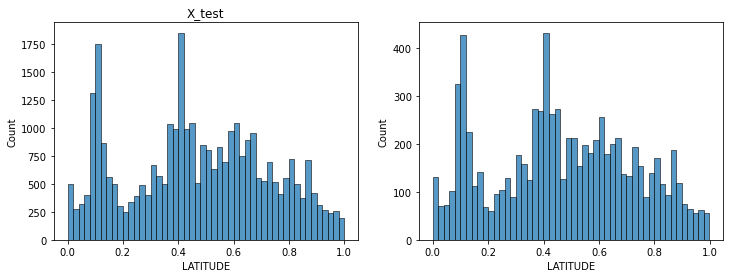

LONGITUDE


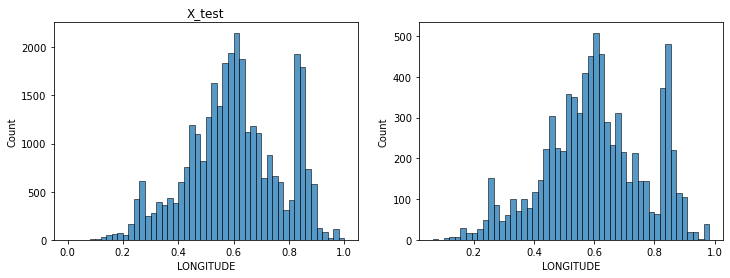

elevation


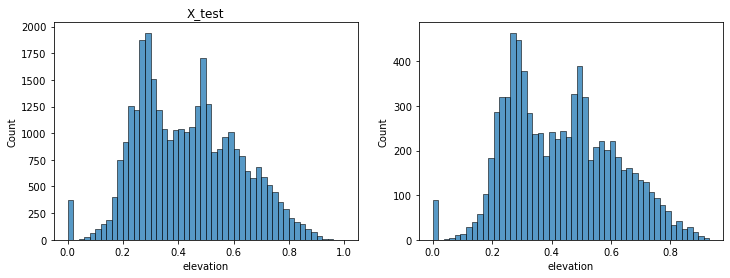

slope


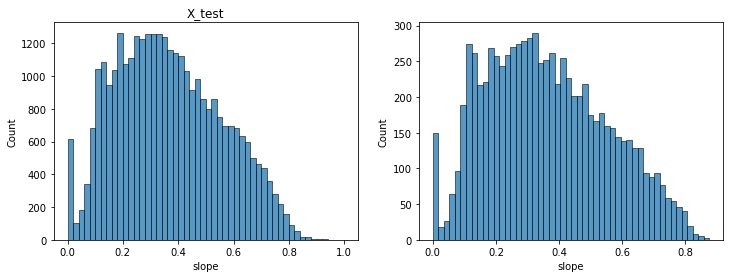

aspect


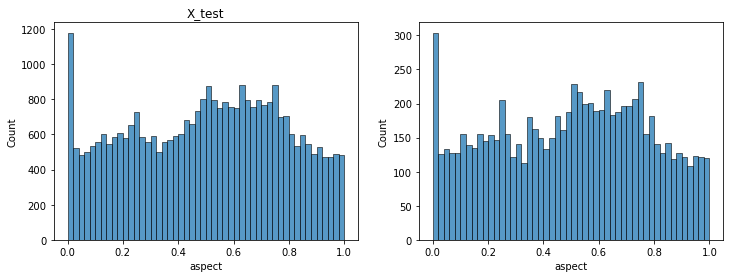

mean_monthly_ppt


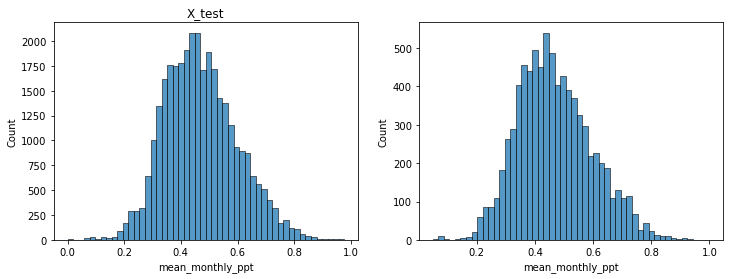

dew_point


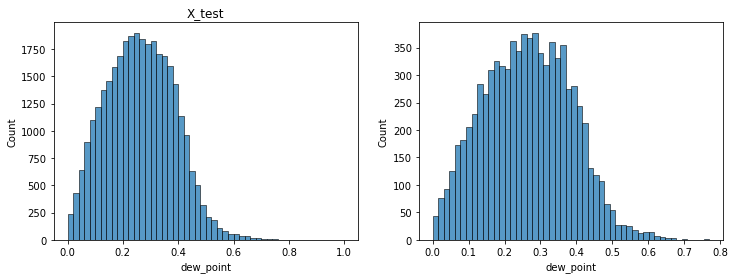

max_temp


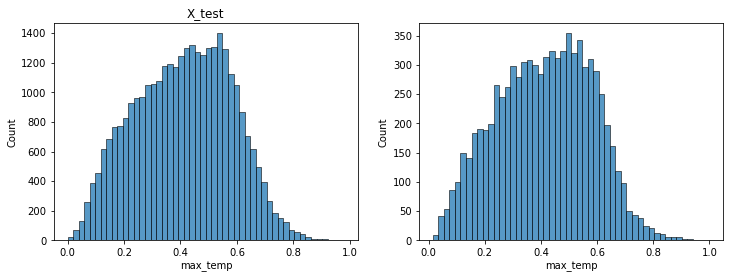

wind_speed


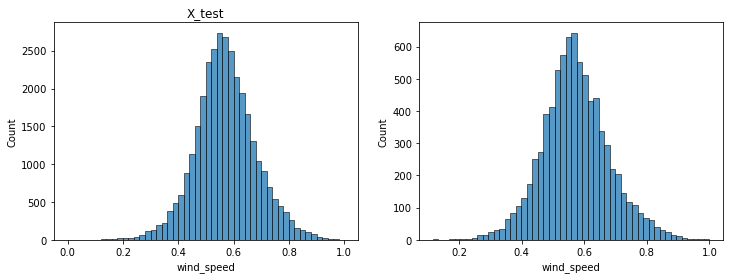

In [154]:
#confirm distributions look similar
for col in X_train.columns[:9]:
    print(col)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

    sns.histplot(x=col, data=X_train, bins=50, ax=ax1)
    ax1.set_title('X_train')
    
    sns.histplot(x=col, data=X_test, bins=50, ax=ax2)
    ax1.set_title('X_test')


    plt.show();

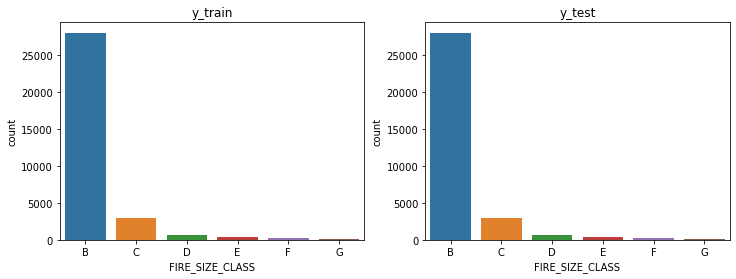

In [152]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

order=['B','C','D','E','F','G']

sns.countplot(x=y_train, ax=ax1, order=order)
ax1.set_title('y_train')

sns.countplot(x=y_train, ax=ax2, order=order)
ax2.set_title('y_test');

### Final Export

In [155]:
#train
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')

#test
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')





If model is not performing sufficiently, try this later:


### Cyclical Ordinal

Month and aspect are actually cyclic ordinal categories so can be treated differently:

https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes

In [ ]:
#list of cardinal directions in clockwise order
cardinal_order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

wfs_cat.loc[:,'aspect_ord'] = wfs_cat['aspect_cat'].copy()

#replace strings with ordinanl numbers
for i, d in enumerate(cardinal_order):
    wfs_cat.loc[:,'aspect_ord'] = wfs_cat['aspect_ord'].replace(d,i)

#change dtype to int
wfs_cat.loc[:,'aspect_ord'] = wfs_cat['aspect_ord'].astype('float')   

In [ ]:
def create_cyclical_ordinal(col, df):

    num = df[col].nunique()
    df[f'{col}_x']=np.sin(2.*np.pi*df[col]/num)
    df[f'{col}_y']=np.cos(2.*np.pi*df[col]/num)

In [ ]:
create_cyclical_ordinal('aspect_ord',wfs_cat)
wfs_cat